## Business Problem

Real Estate firm wants a model to help them accurately price houses.
- How should we price a house based on property features such as lot, footage, bedroom #, bathroom #, and renovations?
<!-- - How should we price a house based on location such as zipcode and waterfront?  -->

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Data

In [2]:
df_column_names = ('data/column_names.md')
df_house = pd.read_csv('data/kc_house_data.csv')

In [3]:
df_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


   - id - unique identifier for a house
   - date - Date house was sold
   - price - Price is prediction target
   - bedrooms - Number of Bedrooms/House
   - bathrooms - Number of bathrooms/bedrooms
   - sqft_livingsquare - footage of the home
   - sqft_lotsquare - footage of the lot
   - floorsTotal - floors (levels) in house
   - waterfront - House which has a view to a waterfront
   - view - # of views
   - condition - How good the condition is ( Overall )
   - grade - overall grade given to the housing unit, based on King County grading system
   - sqft_above - square footage of house apart from basement
   - sqft_basement - square footage of the basement
   - yr_built - Built Year
   - yr_renovated - Year when house was renovated
   - zipcode - zip
   - lat - Latitude coordinate
   - long - Longitude coordinate
   - sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
   - sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Data Exploration 

In [4]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#### Fields with nulls: waterfront, view,  yr_renovated


In [5]:
# print top 5 most frequent values in each column
for col in df_house.columns:
    print(col, '\n', df_house[col].value_counts(normalize=True).head(), '\n\n')

id 
 795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64 


date 
 6/23/2014    0.006575
6/25/2014    0.006066
6/26/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64 


price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.381303
1.5    

#### view is mostly zeros, yr_renovated is mostly zero, waterfront is mostly zero, sqft_basement mostly zero and '?'

In [6]:
df_house['waterfront'].value_counts(normalize=True)
# Make waterfront boolean where nulls are non waterfront properties

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [7]:
df_house['view'].value_counts(normalize=True)
# Make view boolean where nulls are properties without a view

0.0    0.901923
2.0    0.044441
3.0    0.023591
1.0    0.015325
4.0    0.014721
Name: view, dtype: float64

In [8]:
df_house['yr_renovated'].value_counts(normalize=True)
# Make yr_renovated boolean where nulls are unrenovated properties

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

In [9]:
# check all unique values for 'grade'
grade_values = list(df_house['grade'].unique())
grade_values.sort()
grade_values

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [10]:
# check all unique values for 'condition'
condition_values = list(df_house['condition'].unique())
condition_values.sort()
condition_values

[1, 2, 3, 4, 5]

In [11]:
# check for identical home
sum(df_house.duplicated(subset=['id']))

177

In [12]:
# check for identical home / sale date rows
sum(df_house.duplicated(subset=['id','date']))

0

In [13]:
df_house['date'].value_counts(normalize=True)

6/23/2014     0.006575
6/25/2014     0.006066
6/26/2014     0.006066
7/8/2014      0.005880
4/27/2015     0.005834
                ...   
8/30/2014     0.000046
11/30/2014    0.000046
1/31/2015     0.000046
5/17/2014     0.000046
1/17/2015     0.000046
Name: date, Length: 372, dtype: float64

#### Only houses sold in 2014 and 2015 are in our data. This will limit how successful our model will be when used to predict pricing in the 2021 market.

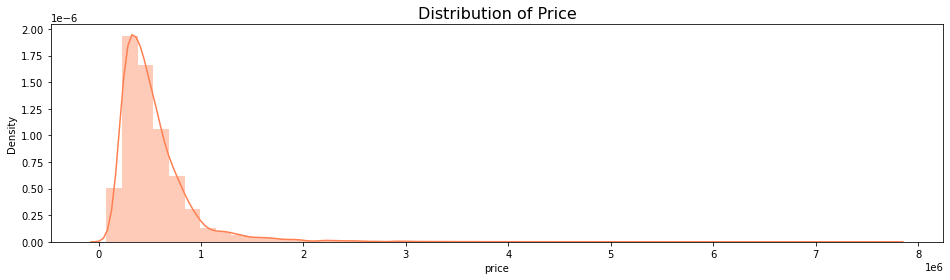

In [14]:
# Plot of the target column price
plt.figure(figsize = (16, 4))
sns.distplot(a = df_house["price"], color = "#FF7F50")
plt.title("Distribution of Price", fontsize=16);

#### skewed distribution

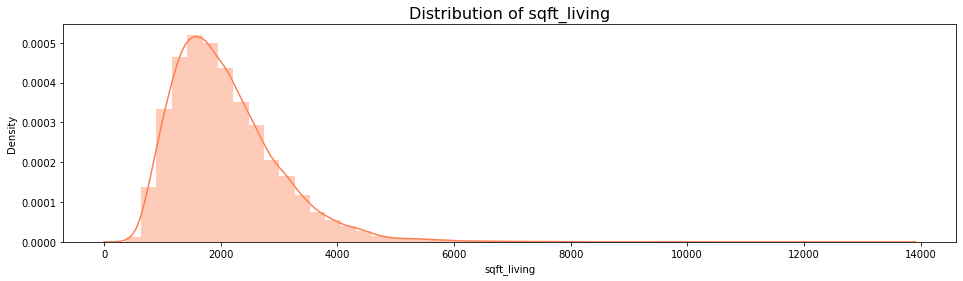

In [15]:
# Plot of the sqft_living column
plt.figure(figsize = (16, 4))
sns.distplot(a = df_house["sqft_living"], color = "#FF7F50")
plt.title("Distribution of sqft_living", fontsize=16);

#### skewed distribution

Should look at the effect of log of price and log of sqft_living on the skew in data prep

## Data Preparation

### Remove unecessary features
Before removing features we will want to run tests to see which features are highly correlated or important to the model. However there are four columns I believe are reasonable to remove.
#### Columns to remove:
   - id - unique identifier for a house
    - not needed for modeling
   - lat - Latitude coordinate
   - long - Longitude coordinate
    - to simplify analysis we will use zipcode for location information

In [16]:
df_house = df_house.drop(['id', 'lat', 'long'], axis=1)

### Missing Values

In [17]:
# Fields with nulls: waterfront, view,  yr_renovated
df_house.waterfront.fillna(0, inplace=True)
df_house.view.fillna(0, inplace=True)
df_house.yr_renovated.fillna(0, inplace=True)

### Reformat Data and Feature Engineer

#### New Feature -  season_sold

In [18]:
# create a year column instead of date
df_house['year_sold'] = df_house['date'].apply(lambda x: int(x[-4:]))
df_house['year_sold'].value_counts(normalize=True)

2014    0.677038
2015    0.322962
Name: year_sold, dtype: float64

In [19]:
# Create function for season of sale to account for seasonality in pricing
def season(month):
    if month == 12 or 1 <= month <= 2:
        season = 'Winter'
    elif 3 <= month <= 5:
        season = 'Spring'
    elif 6 <= month <= 8:
        season = 'Summer'
    else:
        season = 'Fall'
    return season

In [20]:
# to use our function convert date to datetime
df_house['date'] = pd.to_datetime(df_house['date'])
# find month_sold
df_house['month_sold'] = df_house['date'].dt.month

In [21]:
df_house['season_sold'] = df_house['month_sold'].apply(season)
df_house['season_sold'].value_counts(normalize=True)

Spring    0.301801
Summer    0.293004
Fall      0.234107
Winter    0.171089
Name: season_sold, dtype: float64

More houses sold in Spring and Summer than Fall and Winter. This could mean that houses sell at higher prices in Spring and Summer. Intuitively this makes sense based on general knowledge of housing markets.

In [22]:
df_house = df_house.drop(['date','month_sold'], axis=1)

#### New Feature -  basement

In [23]:
# Convert sqft_basement col to basement col which indicates whether or not there is a basement
# assume '0.0' and '?' values mean no basement
df_house['sqft_basement'] = df_house['sqft_basement'].map(lambda x: 0 if x == '?' else x)
# convert column to float
df_house['sqft_basement'] = df_house['sqft_basement'].astype('float')
# add column called basement
df_house['basement'] = df_house['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
# remove the 'sqft_basement' column
df_house = df_house.drop(['sqft_basement'], axis=1)

#### Update Feature - scale grade

In [24]:
# Change scale of grade to 0 - 10 so it's more intuitive
df_house['grade'] = df_house['grade'].map(lambda x: x-3)
grade_values = list(df_house['grade'].unique())
grade_values.sort()
grade_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### New Feature - renovated_in_2000s

In [25]:
# define function for year renovated only counting houses renovated 2000 or later as being renovated
def renovation(year):
    if year >= 2000:
        return 1
    else:
        return 0

In [26]:
# apply function to the 'yr_renovated' column
df_house['yr_renovated']  = df_house['yr_renovated'].apply(renovation)

# rename column
df_house.rename({'yr_renovated': 'renovated_in_2000s'}, axis=1, inplace=True)
df_house['renovated_in_2000s'].value_counts()

0    21218
1      379
Name: renovated_in_2000s, dtype: int64

#### New Feature - viewed

In [27]:
# binary classification of view
def views(count):
    if count > 0:
        return 1
    else:
        return 0

In [28]:
# apply function to 'view' column
df_house['view'] = df_house['view'].apply(views)
# rename view column
df_house.rename({'view': 'viewed'}, axis=1, inplace=True)

In [29]:
df_house['viewed'].value_counts(normalize=True)

0    0.902209
1    0.097791
Name: viewed, dtype: float64

In [30]:
df_house

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,viewed,condition,grade,sqft_above,yr_built,renovated_in_2000s,zipcode,sqft_living15,sqft_lot15,year_sold,season_sold,basement
0,221900.0,3,1.00,1180,5650,1.0,0.0,0,3,4,1180,1955,0,98178,1340,5650,2014,Fall,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0,3,4,2170,1951,0,98125,1690,7639,2014,Winter,1
2,180000.0,2,1.00,770,10000,1.0,0.0,0,3,3,770,1933,0,98028,2720,8062,2015,Winter,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0,5,4,1050,1965,0,98136,1360,5000,2014,Winter,1
4,510000.0,3,2.00,1680,8080,1.0,0.0,0,3,5,1680,1987,0,98074,1800,7503,2015,Winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0,3,5,1530,2009,0,98103,1530,1509,2014,Spring,0
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0,3,5,2310,2014,0,98146,1830,7200,2015,Winter,0
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0,3,4,1020,2009,0,98144,1020,2007,2014,Summer,0
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0,3,5,1600,2004,0,98027,1410,1287,2015,Winter,0


### Multicollinearity

In [31]:
df_features = df_house.drop(['price'], axis=1)

In [32]:
fig_num = len(df_features.columns)

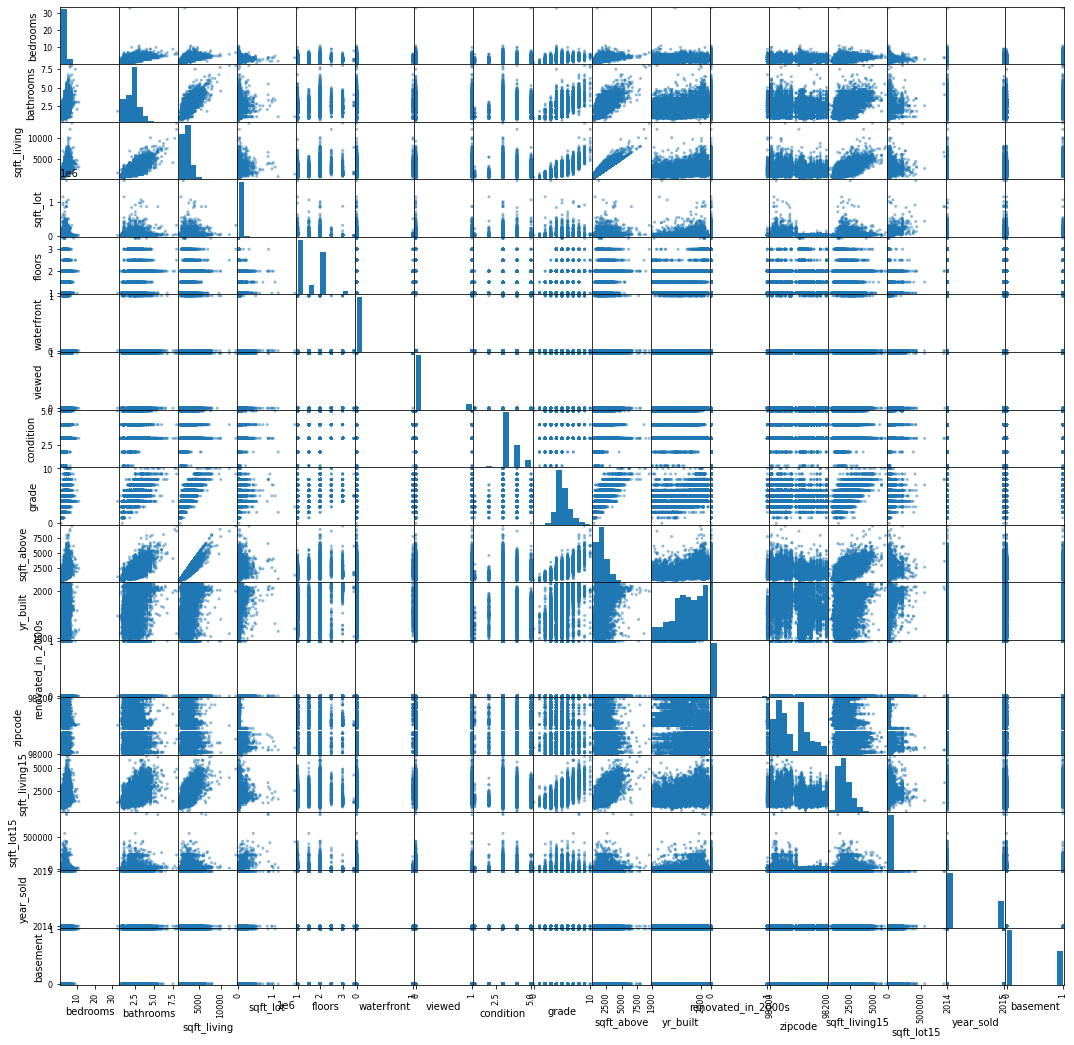

In [33]:
pd.plotting.scatter_matrix(df_features,figsize  = [fig_num, fig_num]);
plt.show()

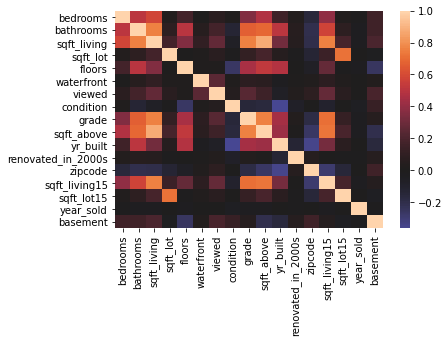

In [34]:
sns.heatmap(df_features.corr(), center=0);

In [35]:
# features correlated above .7 considered highly correlated
abs(df_features.corr()) > 0.7

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,viewed,condition,grade,sqft_above,yr_built,renovated_in_2000s,zipcode,sqft_living15,sqft_lot15,year_sold,basement
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
viewed,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False
sqft_above,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False


In [36]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_features.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
df.drop_duplicates(inplace=True)

In [37]:
df[(df.cc>.7) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758
"(sqft_above, sqft_living15)",0.731767
"(sqft_lot, sqft_lot15)",0.718204
"(sqft_living15, grade)",0.713867


- Remove: sqft_above,sqft_living15, sqft_lot15
- Keeping: grade, sqft_living, bathrooms 
 - intuitively # of bathrooms, grade, and sqft_living should be important for house pricing so let's keep these for now but create a new feature binning sqft_living


In [38]:
# Let's go ahead and drop them from our features
df_features_clean = df_features.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)
#And our original dataframe
df_house = df_house.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)
# We're still left with a few pairs with high correlation:
    # grade and sqft_living
    # bathrooms and sqft_living


In [39]:
# # create new column with bathrooms per square foot
# df_house['bath_per_sqft'] = df_house.apply(lambda row: row['prx'] / row['sqft_living'], axis=1)

### Outliers

In [40]:
print(max(df_house['bedrooms']))
print(min(df_house['bedrooms']))

33
1


In [41]:
print(max(df_house['bathrooms']))
print(min(df_house['bathrooms']))

8.0
0.5


In [42]:
print(max(df_house['floors']))
print(min(df_house['floors']))

3.5
1.0


In [43]:
quantity_features = ['bedrooms', 'bathrooms', 'floors']

In [44]:
# remove all rows which contain value more than three standard deviations away from mean
for var in quantity_features:
    df_house = df_house[np.abs(df_house[var]-df_house[var].mean()) <= (3*df_house[var].std())]

In [45]:
print(max(df_house['bedrooms']))
print(min(df_house['bedrooms']))

6
1


In [46]:
print(max(df_house['bathrooms']))
print(min(df_house['bathrooms']))

4.25
0.5


In [47]:
print(max(df_house['floors']))
print(min(df_house['floors']))

3.0
1.0


### Continuous and Categorical - Feature Engineering cont'

In [48]:
df_features_clean.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'viewed', 'condition', 'grade', 'yr_built',
       'renovated_in_2000s', 'zipcode', 'year_sold', 'season_sold',
       'basement'],
      dtype='object')

In [49]:
continuous = ['sqft_living']

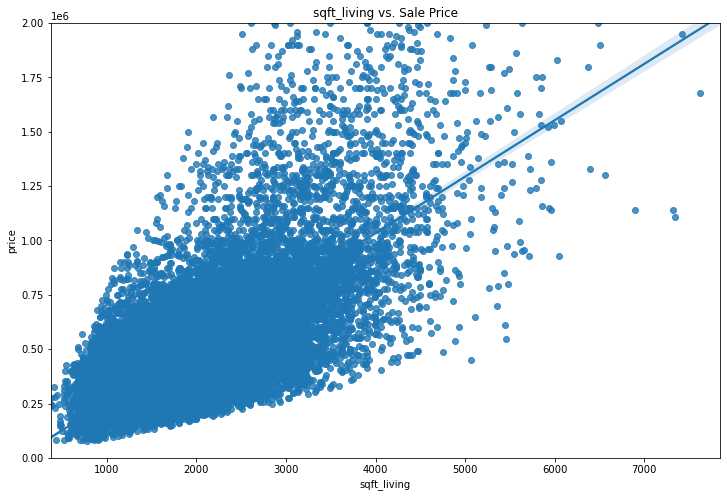

In [50]:
# price vs continuous variables
for variable in continuous:
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    plt.ylim(0,2000000)
    sns.regplot(x=variable, y='price', data=df_house)
    plt.title("{} vs. Sale Price".format(variable))


In [51]:
# assign categorical variables to a list
categorical = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'viewed', 'condition', 'grade', 
                         'yr_built', 'renovated_in_2000s', 'year_sold','season_sold',
                         'basement', 'sqft_lot','zipcode']

In [52]:
#Check that we included all features:
len(categorical) + len(continuous) == len(df_features_clean.columns) 

True

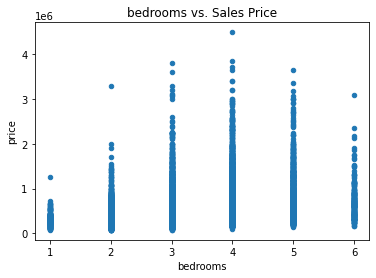

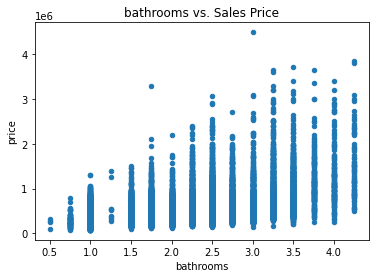

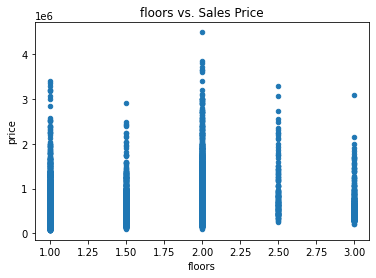

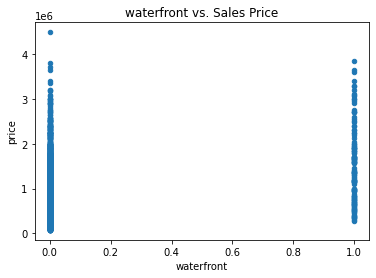

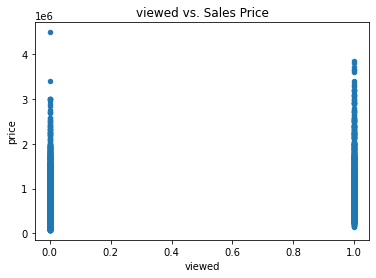

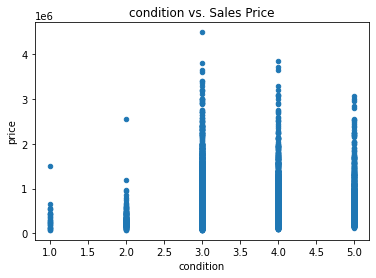

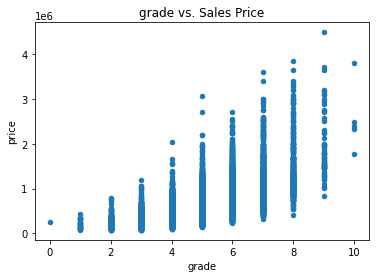

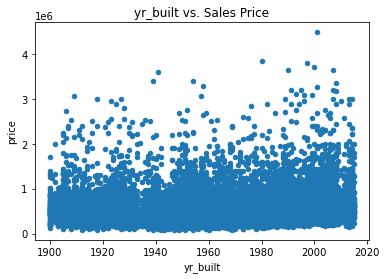

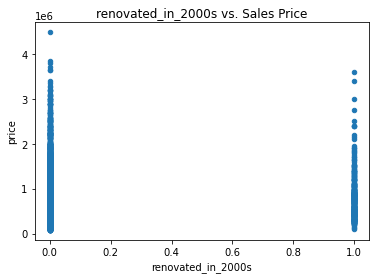

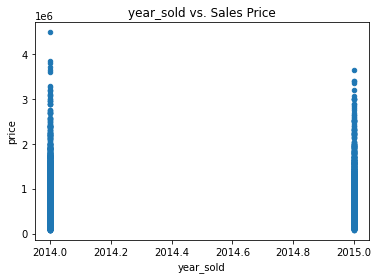

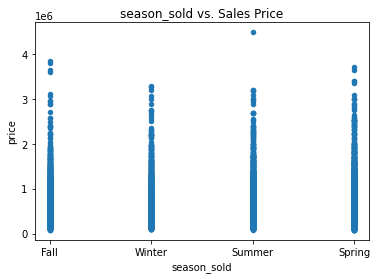

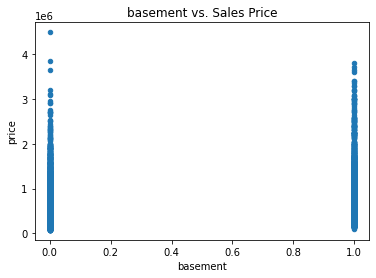

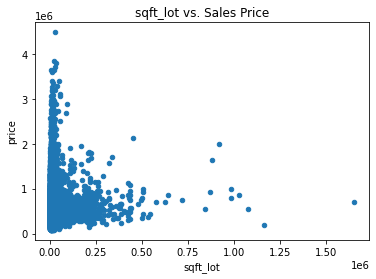

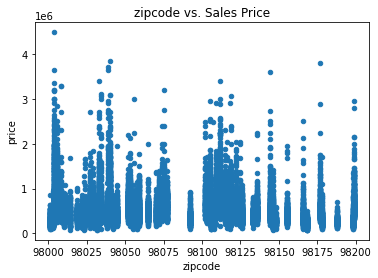

In [53]:
# let's take a look at the scatter plots to show how these behave more like discrete variables

for column in categorical:
    df_house.plot.scatter(x=column, y='price')
    plt.title("{} vs. Sales Price".format(column))
    plt.show()

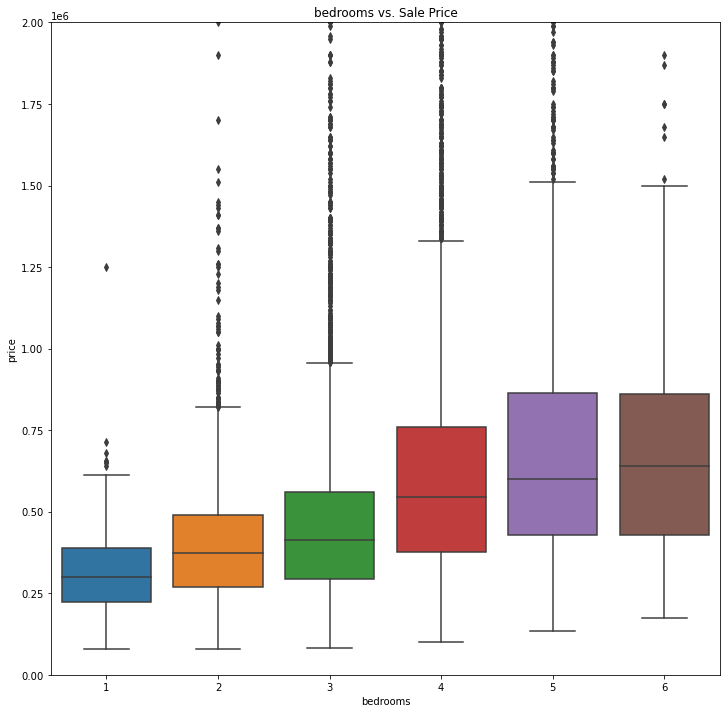

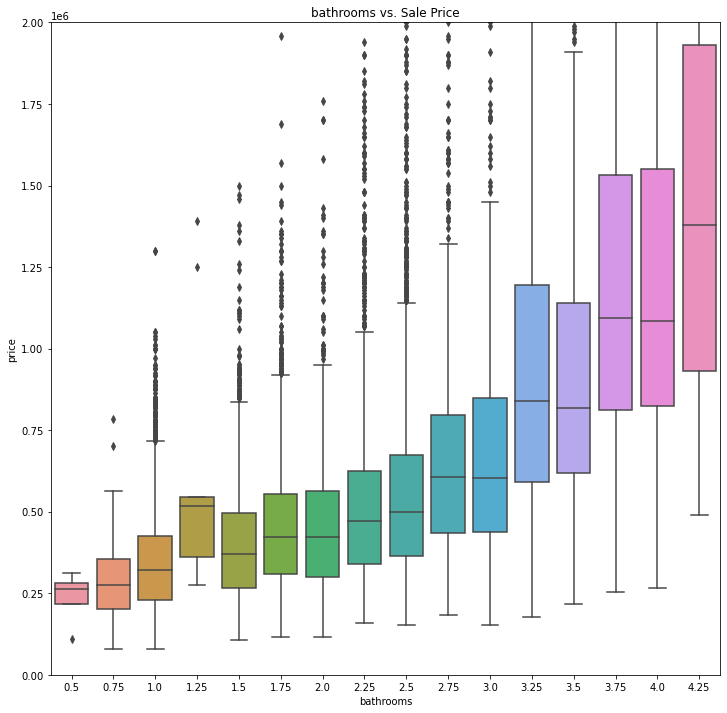

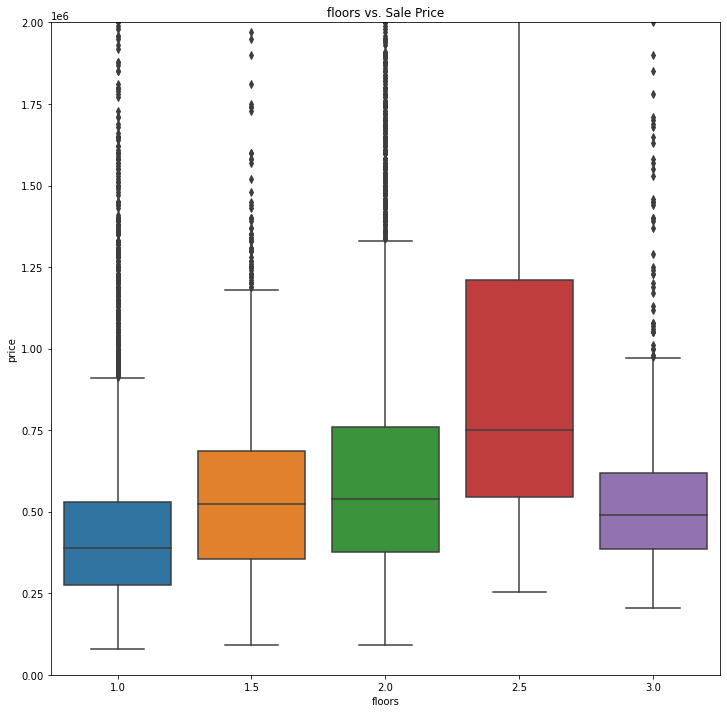

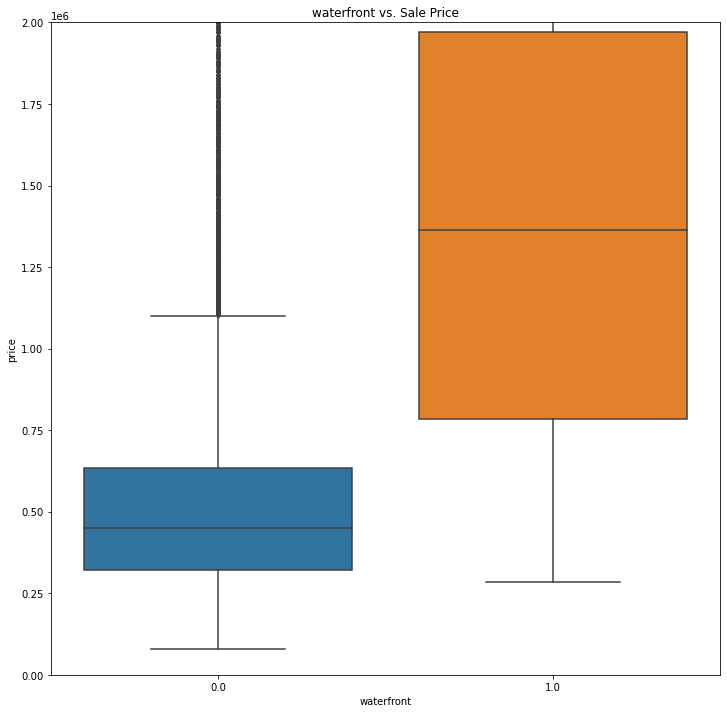

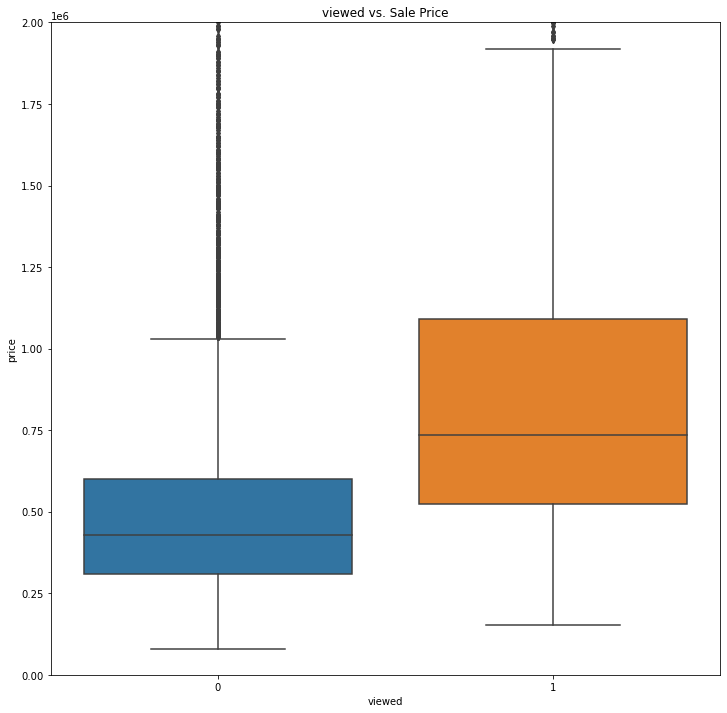

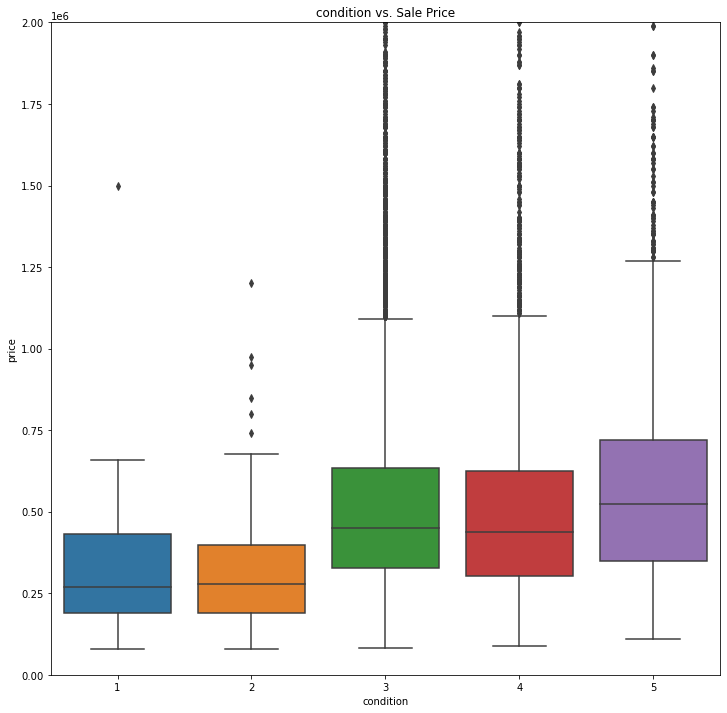

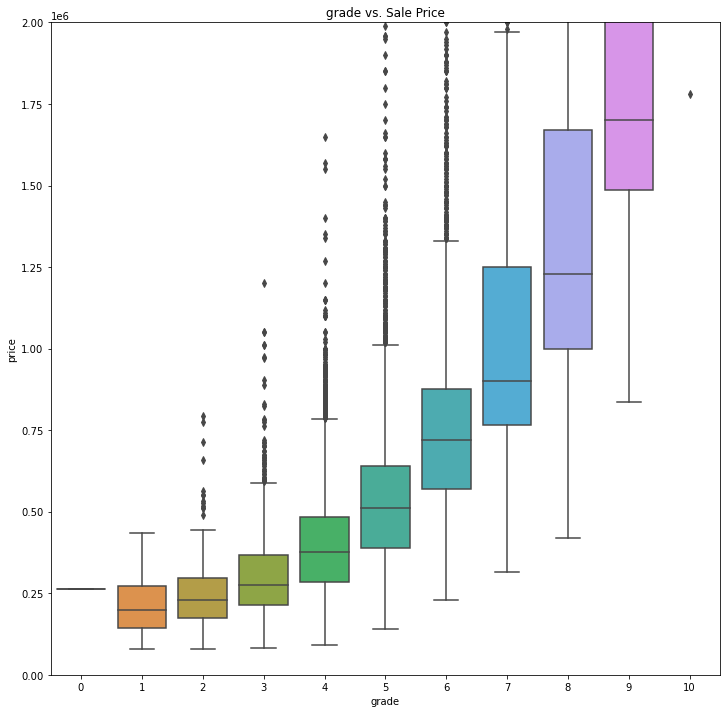

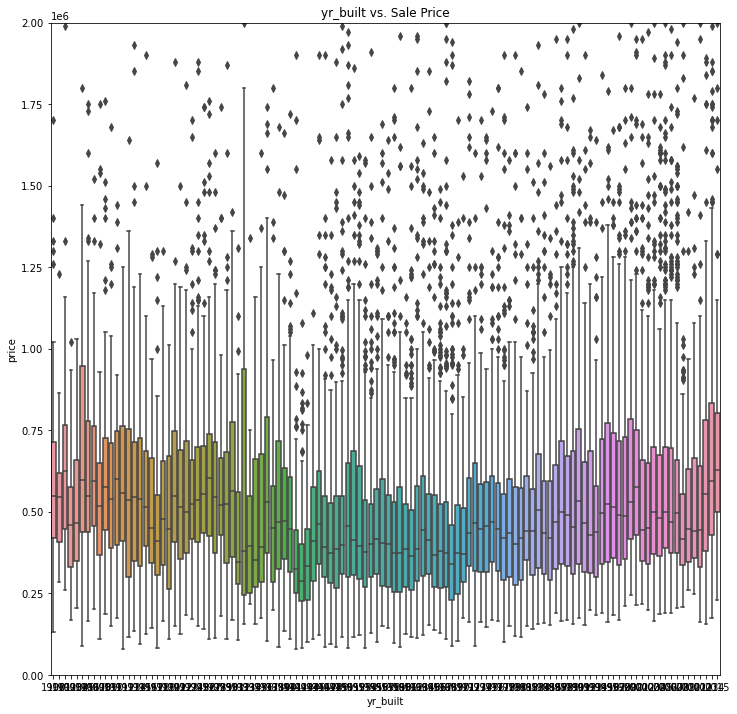

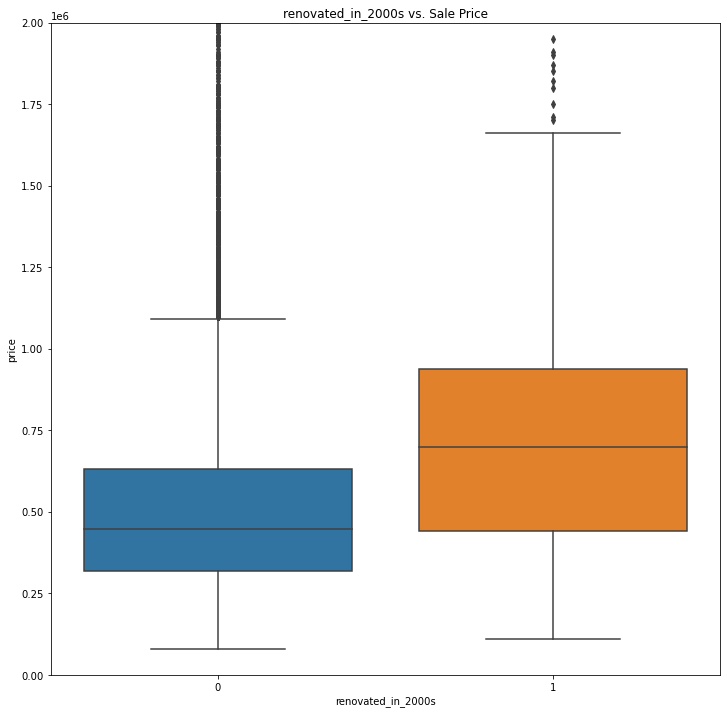

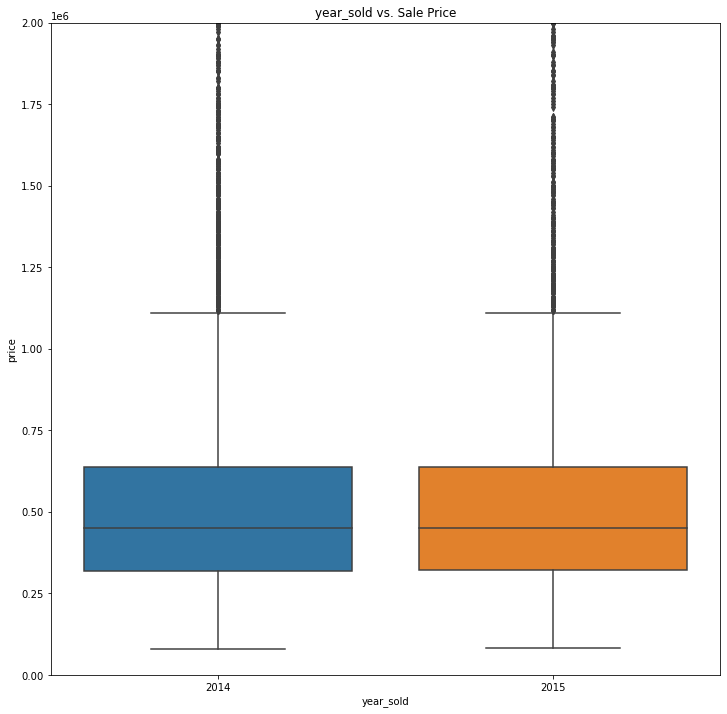

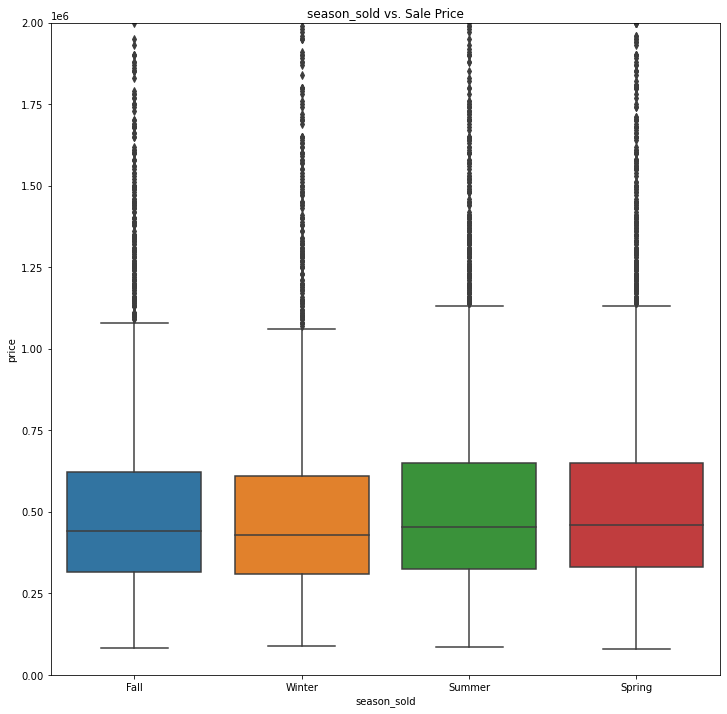

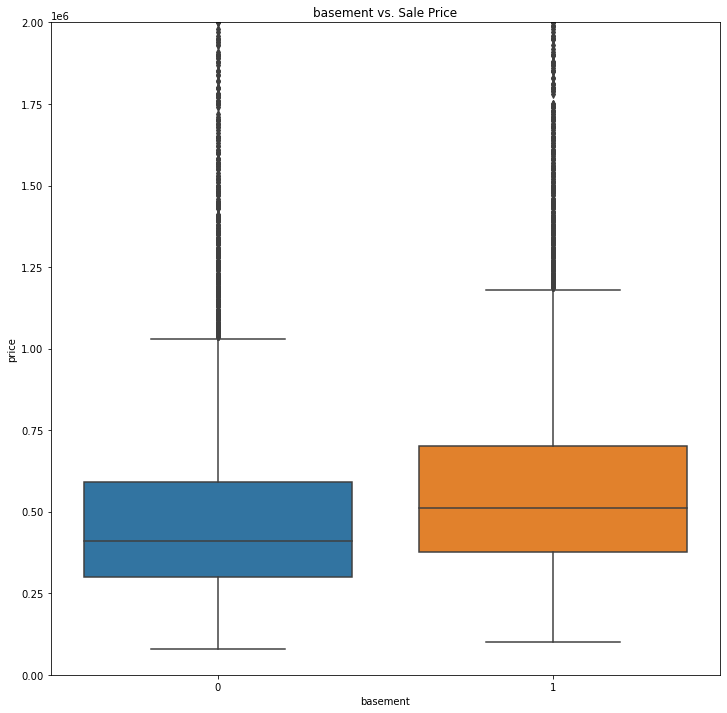

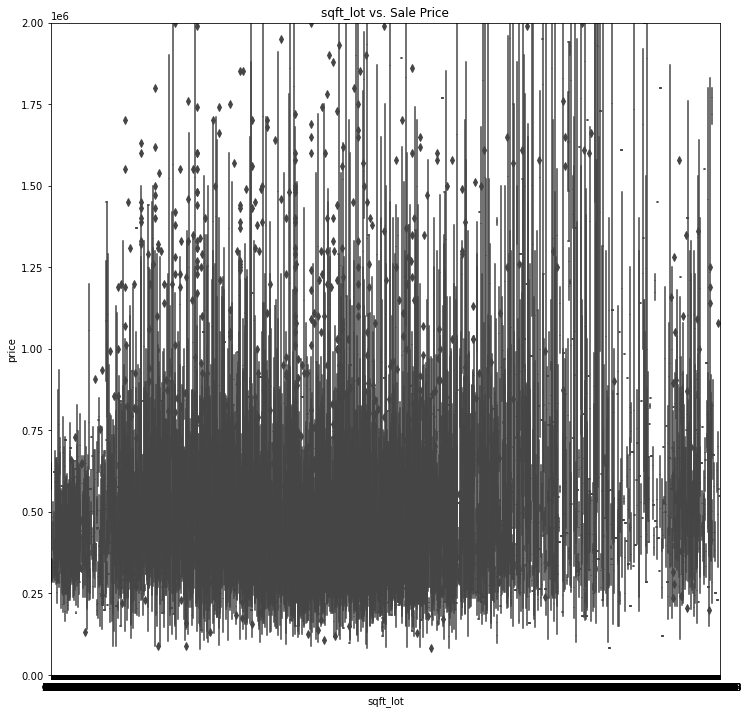

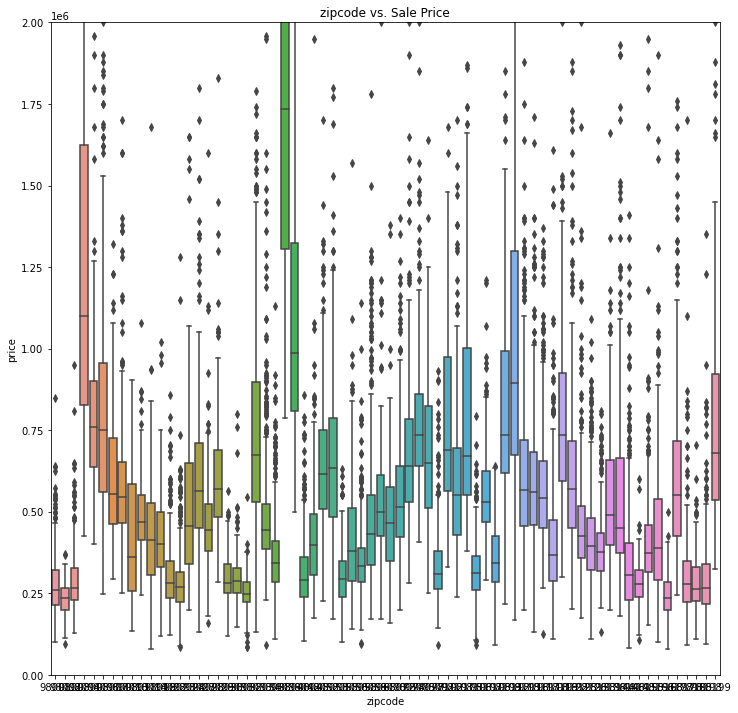

In [54]:
# price vs categorical variables
for variable in categorical:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(0,2000000)
    sns.boxplot(x=variable, y='price', data=df_house)
    plt.title("{} vs. Sale Price".format(variable))


- yr_built is hard to interpret
- year_sold difference in price visually looks negligible
- season_sold Spring/Summer do have slightly higher prices than Fall/Winter

#### New Features - binned categoricals

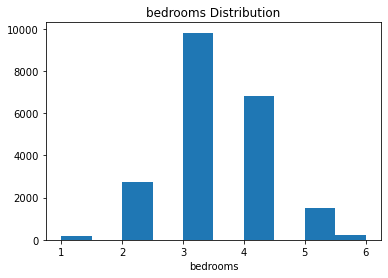

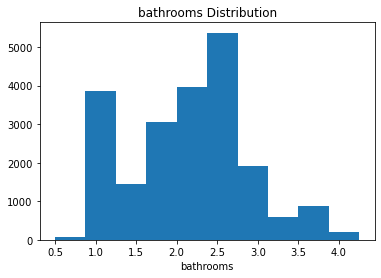

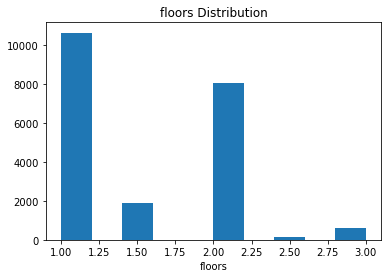

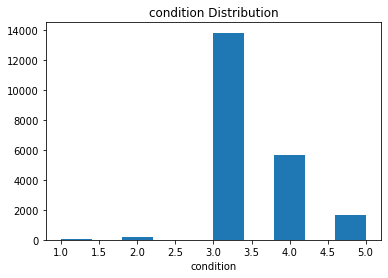

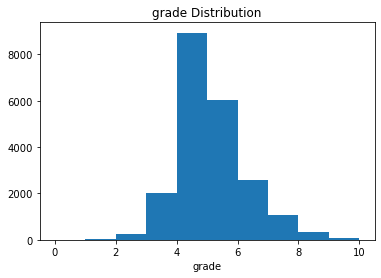

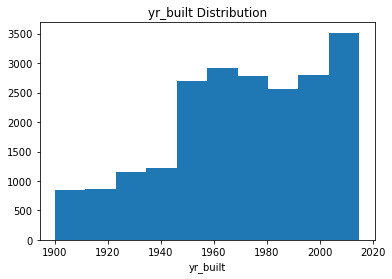

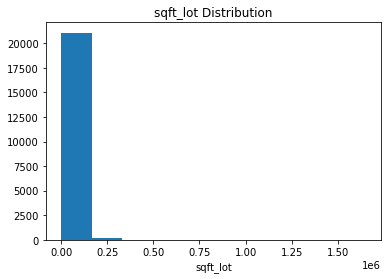

In [55]:
# Let's look at the histograms for our categorical variables to see if we want to bin them
# I've taken out variables which are already boolean or categorized like Season
categorical_bin = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_built', 'sqft_lot']
for column in categorical_bin:
    plt.hist(df_house[column])
    plt.xlabel(column)
    plt.title("{} Distribution".format(column))
    plt.show()

In [56]:
# and we will also take a look at their summary statistics
categorical_bin = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_built', 'sqft_lot']
for column in categorical_bin:
    print(df_house[column].describe())

count    21357.000000
mean         3.348083
std          0.865467
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: bedrooms, dtype: float64
count    21357.000000
mean         2.089139
std          0.722480
min          0.500000
25%          1.500000
50%          2.250000
75%          2.500000
max          4.250000
Name: bathrooms, dtype: float64
count    21357.000000
mean         1.488926
std          0.537816
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.000000
Name: floors, dtype: float64
count    21357.000000
mean         3.411434
std          0.651325
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64
count    21357.000000
mean         4.635155
std          1.144854
min          0.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         10.000

In [57]:
df_house['sqft_lot'].describe().apply(lambda x: format(x, 'f'))

count      21357.000000
mean       14909.726507
std        40828.962049
min          520.000000
25%         5034.000000
50%         7590.000000
75%        10584.000000
max      1651359.000000
Name: sqft_lot, dtype: object

In [58]:
# based on some intuition and the quantile distributions, we will define our bin ranges.
bedrooms_bins = [0, 2, 3, 4, 33]
bathrooms_bins = [0, 1, 2, 3, 8] 
floors_bins = [0,1,2,4]# when plotted with price 2 floors looks like a higher price group
condition_bins = [0,2,3,5] # when plotted with price condition 2 and under is a lower price group than 2+
grade_bins = [0,4,5,7,10]
yr_built_bins = [1900, 1950, 1975, 2000, 2015] 
sqft_lot_bins = [0,2500,5000,7500,10000,10000000]

In [59]:
# now lets convert these columns to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin
df_house['bedrooms'] = pd.cut(df_house['bedrooms'], bedrooms_bins)
df_house['bathrooms'] = pd.cut(df_house['bathrooms'], bathrooms_bins)
df_house['floors'] = pd.cut(df_house['floors'], floors_bins)
df_house['condition'] = pd.cut(df_house['condition'], condition_bins)
df_house['grade'] = pd.cut(df_house['grade'], grade_bins)
df_house['yr_built'] = pd.cut(df_house['yr_built'], yr_built_bins)
df_house['sqft_lot'] = pd.cut(df_house['sqft_lot'], sqft_lot_bins)
#df_house['zipcode'] = pd.cut(df_house['zipcode'], zipcode_bins)

In [60]:
# and we will also take a look at the distribution across bins 
for column in categorical_bin:
    print(df_house[column].value_counts(normalize=True))

(2, 3]     0.459568
(3, 4]     0.319567
(0, 2]     0.138315
(4, 33]    0.082549
Name: bedrooms, dtype: float64
(2, 3]    0.437093
(1, 2]    0.300979
(0, 1]    0.183780
(3, 8]    0.078148
Name: bathrooms, dtype: float64
(0, 1]    0.498291
(1, 2]    0.466498
(2, 4]    0.035211
Name: floors, dtype: float64
(2, 3]    0.647563
(3, 5]    0.343119
(0, 2]    0.009318
Name: condition, dtype: float64
(0, 4]     0.526456
(4, 5]     0.282216
(5, 7]     0.172364
(7, 10]    0.018964
Name: grade, dtype: float64
(1975, 2000]    0.284814
(1950, 1975]    0.268500
(1900, 1950]    0.237847
(2000, 2015]    0.208839
Name: yr_built, dtype: float64
(10000, 10000000]    0.282062
(5000, 7500]         0.244885
(7500, 10000]        0.226905
(2500, 5000]         0.176570
(0, 2500]            0.069579
Name: sqft_lot, dtype: float64


### Log Transformations

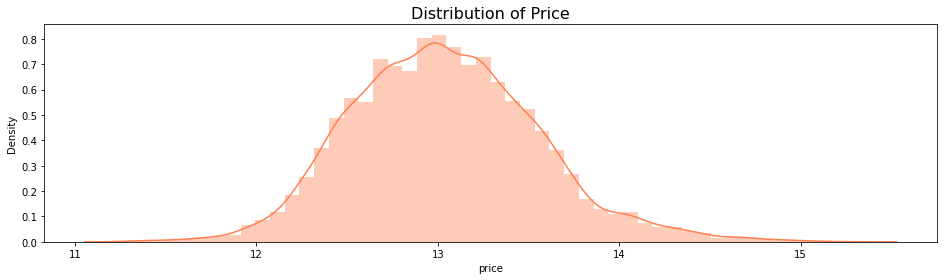

In [61]:
non_normal = ['price']
for feat in non_normal:
    df_house[feat] = df_house[feat].map(lambda x: np.log(x))
plt.figure(figsize = (16, 4))
sns.distplot(a = df_house["price"], color = "#FF7F50")
plt.title("Distribution of Price", fontsize=16);

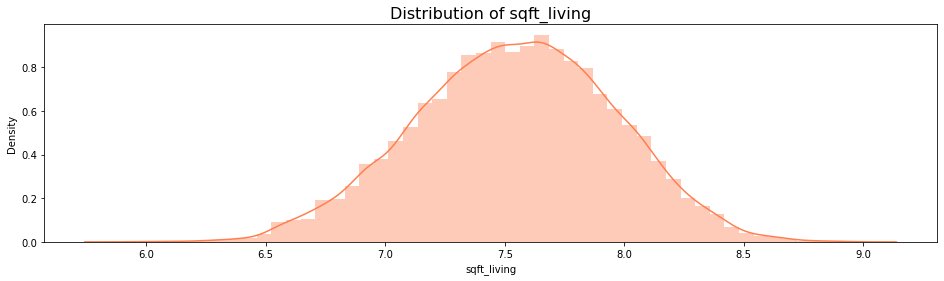

In [62]:
non_normal_2 = ['sqft_living']
for feat in non_normal_2:
    df_house[feat] = df_house[feat].map(lambda x: np.log(x))
plt.figure(figsize = (16, 4))
sns.distplot(a = df_house["sqft_living"], color = "#FF7F50")
plt.title("Distribution of sqft_living", fontsize=16);

### split data test and train

In [63]:
# Divide dataset into X predictors and y target
x = df_house.drop(['price'], axis=1)
y = df_house[['price']]

In [64]:
# Split the data into 80% training and 20% test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [65]:
# Validate rows in splits look as expected
print(len(x_train), len(x_test), len(y_train), len(y_test))

17085 4272 17085 4272


### one-hot encode categorical variables

In [66]:
categorical

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'viewed',
 'condition',
 'grade',
 'yr_built',
 'renovated_in_2000s',
 'year_sold',
 'season_sold',
 'basement',
 'sqft_lot',
 'zipcode']

In [67]:
# Convert category variables data type
# One-hot encode my categorical variables.
needs_one_hot = categorical.copy()
# These are already one-hot binary
needs_one_hot.remove('waterfront')
needs_one_hot.remove('viewed')
needs_one_hot.remove('renovated_in_2000s')
needs_one_hot.remove('basement')

x_train[needs_one_hot] = x_train[needs_one_hot].astype('category')
x_test[needs_one_hot] = x_test[needs_one_hot].astype('category')

In [68]:
## one hot encode categoricals training set
x_train_ohe = pd.get_dummies(x_train[needs_one_hot])
x_train_ohe.head()

,"bedrooms_(0, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 33]","bathrooms_(0, 1]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 8]","floors_(0, 1]","floors_(1, 2]",...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
16214,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12438,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7668,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14679,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6031,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
## one hot encode categoricals test set
x_test_ohe = pd.get_dummies(x_test[needs_one_hot])
x_test_ohe.head()

,"bedrooms_(0, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 33]","bathrooms_(0, 1]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 8]","floors_(0, 1]","floors_(1, 2]",...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
15235,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
7564,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18362,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5922,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11844,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [70]:
## Concatenate OHE columns with original dataframe, dropping OHE original features
x_train = pd.concat([x_train, x_train_ohe], axis=1)
x_train.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'viewed', 'condition', 'grade', 
                          'yr_built', 'renovated_in_2000s', 'year_sold','season_sold',
                          'basement', 'sqft_lot','zipcode'], axis=1, inplace=True)
x_train.head()

,sqft_living,"bedrooms_(0, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 33]","bathrooms_(0, 1]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 8]","floors_(0, 1]",...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
16214,7.339538,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12438,7.533694,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7668,7.610853,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14679,7.522941,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6031,7.138867,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
## Concatenate OHE columns with original dataframe, dropping OHE original features
x_test = pd.concat([x_test, x_test_ohe], axis=1)
x_test.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'viewed', 'condition', 'grade', 
                          'yr_built', 'renovated_in_2000s', 'year_sold','season_sold',
                          'basement', 'sqft_lot','zipcode'], axis=1, inplace=True)
x_test.head()

,sqft_living,"bedrooms_(0, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 33]","bathrooms_(0, 1]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 8]","floors_(0, 1]",...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
15235,6.966024,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
7564,7.012115,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18362,6.917706,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5922,7.346010,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11844,6.791221,0,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


### Model Iteration Variables

In [72]:
# create list so that random forest model important features are named
rfm_columns = list(x_train.columns)
# create list so that ols parameters in results summary are named
xname_columns = list(x_train.columns)

In [73]:
#add const to beginning of list for ols param names
xname_columns.insert(0,'const')

In [74]:
#feature selection for second ols model
xname2_columns = xname_columns.copy()

# items to be removed
unwanted_feats = {'grade_(4, 5]', 'grade_(5, 7]','grade_(7, 10]','floors_(2, 4]','yr_built_(1900, 1950]',
                             'yr_built_(2000, 2015]','season_sold_Fall','season_sold_Summer','sqft_lot_(5000, 7500]',
                             'zipcode_98024','zipcode_98070','zipcode_98072', 'zipcode_98077','zipcode_98133'}
  
xname2_columns = [ele for ele in xname2_columns if ele not in unwanted_feats]
  
# printing modified list
print("New list after removing unwanted feats: ", xname2_columns)

New list after removing unwanted feats:  ['const', 'sqft_living', 'bedrooms_(0, 2]', 'bedrooms_(2, 3]', 'bedrooms_(3, 4]', 'bedrooms_(4, 33]', 'bathrooms_(0, 1]', 'bathrooms_(1, 2]', 'bathrooms_(2, 3]', 'bathrooms_(3, 8]', 'floors_(0, 1]', 'floors_(1, 2]', 'condition_(0, 2]', 'condition_(2, 3]', 'condition_(3, 5]', 'grade_(0, 4]', 'yr_built_(1950, 1975]', 'yr_built_(1975, 2000]', 'year_sold_2014', 'year_sold_2015', 'season_sold_Spring', 'season_sold_Winter', 'sqft_lot_(0, 2500]', 'sqft_lot_(2500, 5000]', 'sqft_lot_(7500, 10000]', 'sqft_lot_(10000, 10000000]', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_

In [75]:
# Features for second iteration of Random Forest Model - train
rf2_feats = ['sqft_living', 'grade_(0, 4]', 'yr_built_(1900, 1950]', 'grade_(5, 7]','zipcode_98004','zipcode_98023',
             'sqft_lot_(2500, 5000]', 'grade_(7, 10]','zipcode_98092','zipcode_98042', 'zipcode_98001','grade_(4, 5]',
             'yr_built_(1950, 1975]','zipcode_98033','zipcode_98038','zipcode_98002','zipcode_98003','zipcode_98058',
             'zipcode_98115','zipcode_98040'] 
x_train_rf2 = x_train[rf2_feats]

# Features for second iteration of Random Forest Model - test
x_test_rf2 = x_test[rf2_feats]


In [76]:
x_train.head()

,sqft_living,"bedrooms_(0, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 33]","bathrooms_(0, 1]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 8]","floors_(0, 1]",...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
16214,7.339538,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12438,7.533694,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7668,7.610853,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14679,7.522941,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6031,7.138867,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
x_train_ols2 = x_train.drop(['grade_(4, 5]', 'grade_(5, 7]','grade_(7, 10]','floors_(2, 4]','yr_built_(1900, 1950]',
                             'yr_built_(2000, 2015]','season_sold_Fall','season_sold_Summer','sqft_lot_(5000, 7500]',
                             'zipcode_98024','zipcode_98070','zipcode_98072', 'zipcode_98077','zipcode_98133'], axis=1)
x_test_ols2 = x_test.drop(['grade_(4, 5]', 'grade_(5, 7]','grade_(7, 10]','floors_(2, 4]','yr_built_(1900, 1950]',
                             'yr_built_(2000, 2015]','season_sold_Fall','season_sold_Summer','sqft_lot_(5000, 7500]',
                             'zipcode_98024','zipcode_98070','zipcode_98072', 'zipcode_98077','zipcode_98133'], axis=1)
x_test_ols2.head()

,sqft_living,"bedrooms_(0, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 33]","bathrooms_(0, 1]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 8]","floors_(0, 1]",...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
15235,6.966024,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
7564,7.012115,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18362,6.917706,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5922,7.346010,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11844,6.791221,0,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


### Feature Scaling

In [78]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [79]:
x_train_ols2 = scaler.fit_transform(x_train_ols2)
x_test_ols2 = scaler.transform(x_test_ols2)

### Model 1

#### Linear Regression

In [80]:
linear_model = LinearRegression()
# Train the model on training data
linear_model.fit(x_train, y_train)

LinearRegression()

#### Linear model prediction

In [81]:
# Predict on test data
predictions = linear_model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(rmse)

0.19803609919251683


In [82]:
# Get how well it performed
mae_linear = mean_absolute_error(y_test, predictions)

print("Linear: {:,}".format(mae_linear))

Linear: 0.14423826491281666


<AxesSubplot:xlabel='price'>

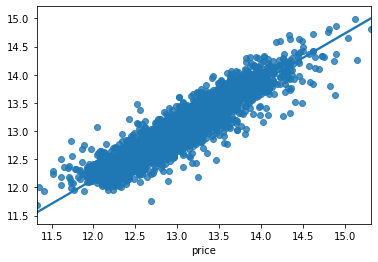

In [83]:
sns.regplot(x=y_test, y=predictions)

In [84]:
y_hat_train = linear_model.predict(x_train)
y_hat_test = linear_model.predict(x_test)

In [85]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [86]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.038139886774464414
Test Mean Squarred Error: 0.039218296583388365


In [87]:
# Train Mean Squarred Error: 0.09852984028003561
# Test Mean Squarred Error: 0.0995161577140719

In [88]:
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_hat_train),
                r2_score(y_test, y_hat_test)))

R^2 train: 0.856, test: 0.850


In [89]:
#R^2 train: 0.629, test: 0.620

### Model 2

#### Decision Tree Regressor

In [90]:
tree_model = DecisionTreeRegressor()

# Train the model on training data
tree_model.fit(x_train, y_train)

# Predict on test data
predictions = tree_model.predict(x_test)

#### Tree model prediction

In [91]:
# Get how well it performed
mae_tree = mean_absolute_error(y_test, predictions)

print("Tree: {:,}".format(mae_tree))

Tree: 0.20733758793534132


<AxesSubplot:xlabel='price'>

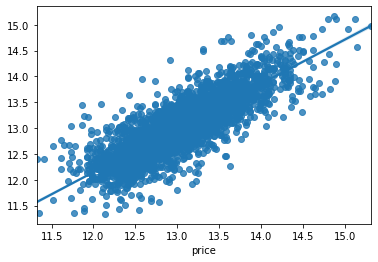

In [92]:
sns.regplot(x=y_test, y=predictions)

In [93]:
y_hat_train = tree_model.predict(x_train)
y_hat_test = tree_model.predict(x_test)

In [94]:
#train_residuals = y_hat_train - y_train
#test_residuals = y_hat_test - y_test

In [95]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.00016094854427852004
Test Mean Squarred Error: 0.0848163992356105


In [96]:
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_hat_train),
                r2_score(y_test, y_hat_test)))


R^2 train: 0.999, test: 0.676


 isssues with overfitting

### Model 3

#### Random Forest Regressor

In [97]:
rf_model = RandomForestRegressor()

# Train the model on training data
rf_model.fit(x_train, y_train)

# Predict on test data
predictions = rf_model.predict(x_test)

#### Random Forest model prediction

In [98]:
# Get how well it performed
mae_rf = mean_absolute_error(y_test, predictions)

print("Random Forest: {:,}".format(mae_rf))

Random Forest: 0.15621599370318473


<AxesSubplot:xlabel='price'>

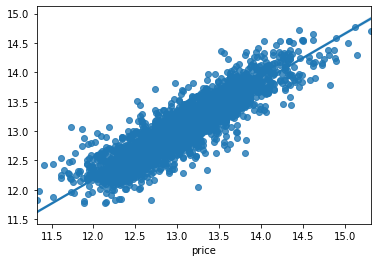

In [99]:
sns.regplot(x=y_test, y=predictions)

In [100]:
y_hat_train = rf_model.predict(x_train)
y_hat_test = rf_model.predict(x_test)

In [101]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.006833147455952221
Test Mean Squarred Error: 0.047854429562705955


In [102]:
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_hat_train),
                r2_score(y_test, y_hat_test)))

R^2 train: 0.974, test: 0.817


In [103]:
# R^2 train: 0.927, test: 0.578

In [104]:
# feats = {} # a dict to hold feature_name: feature_importance
# for feature, importance in zip(x_train.columns, model.feature_importances_):
#     feats[feature] = importance #add the name/value pair 

# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

<AxesSubplot:>

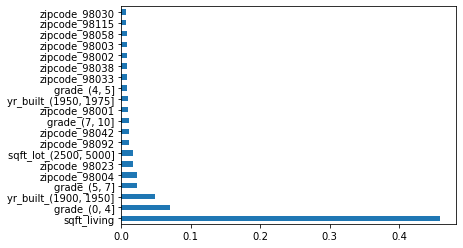

In [105]:
feat_importances = pd.Series(rf_model.feature_importances_, index = rfm_columns)
feat_importances.nlargest(20).plot(kind='barh')

In [106]:
feat_importances.nlargest(20)

sqft_living              0.459631
grade_(0, 4]             0.070201
yr_built_(1900, 1950]    0.047959
grade_(5, 7]             0.022092
zipcode_98004            0.021954
zipcode_98023            0.016912
sqft_lot_(2500, 5000]    0.016746
zipcode_98092            0.010988
zipcode_98042            0.010501
grade_(7, 10]            0.010379
zipcode_98001            0.010089
yr_built_(1950, 1975]    0.008817
grade_(4, 5]             0.008665
zipcode_98033            0.008585
zipcode_98038            0.008201
zipcode_98002            0.008027
zipcode_98003            0.007730
zipcode_98058            0.007520
zipcode_98115            0.007229
zipcode_98030            0.006909
dtype: float64

### Model 4

#### OLS

In [107]:
x_train1 = sm.add_constant(x_train)

In [108]:
x_test1 = sm.add_constant(x_test)

In [109]:
result = sm.OLS(y_train,x_train1).fit()

#### OLS model prediction

In [110]:
print(result.rsquared, result.rsquared_adj)

0.8563583837968929 0.8555466581578831


In [111]:
print(result.summary(xname= xname_columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1055.
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:39:16   Log-Likelihood:                 3662.7
No. Observations:               17085   AIC:                            -7131.
Df Residuals:                   16988   BIC:                            -6380.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Looking at our OLS summary all grade bins except grade_(0, 4] have high pvalue and high st err

OTHER HIGH PVALUES
grade_(4, 5]
grade_(5, 7]
grade_(7, 10]
floors_(2, 4]
yr_built_(1900, 1950]
yr_built_(2000, 2015]
season_sold_Fall              
season_sold_Summer
sqft_lot_(5000, 7500]          
zipcode_98024 
zipcode_98070 
zipcode_98072 
zipcode_98077
zipcode_98133

### Model Reiteration and Feature Selection

#### Random Forest Regressor - 2

Using the Feature Importance graph let's take a look at random forest model with only the top 20 features

<AxesSubplot:>

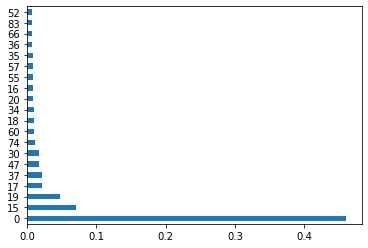

In [112]:
feat_importances = pd.Series(rf_model.feature_importances_)
feat_importances.nlargest(20).plot(kind='barh')

In [113]:
#rf_model_2_index = [0,15,19,17,30,20,26,27,25,28,33,2,14,18,13,31,32,3,16,23]

In [114]:
rf2_model = RandomForestRegressor()

# Train the model on training data
rf2_model.fit(x_train_rf2, y_train)

RandomForestRegressor()

#### Random Forest model prediction -2

In [115]:
# Predict on test data
predictions = rf2_model.predict(x_test_rf2)

In [116]:
##### Get how well it performed
mae_rf = mean_absolute_error(y_test, predictions)

print("Random Forest: {:,}".format(mae_rf))

Random Forest: 0.22517524119864782


<AxesSubplot:xlabel='price'>

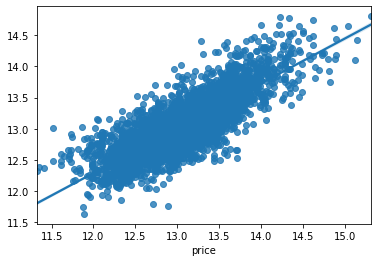

In [117]:
sns.regplot(x=y_test, y=predictions)

In [118]:
y_hat_train = rf2_model.predict(x_train_rf2)
y_hat_test = rf2_model.predict(x_test_rf2)

In [119]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.050451008604447976
Test Mean Squarred Error: 0.08824661678762068


In [120]:
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_hat_train),
                r2_score(y_test, y_hat_test)))

R^2 train: 0.810, test: 0.663


Selecting top 20 features did not improve our Random Forest Model performance

Our original Mean Squared Error:
Train Mean Squarred Error: 0.006888463386013245
Test Mean Squarred Error: 0.04811152977830136

Our error has increased and our R^2 scores have gone down, this indicates that selecting features solely based on their importance is not a sound strategy.

<AxesSubplot:>

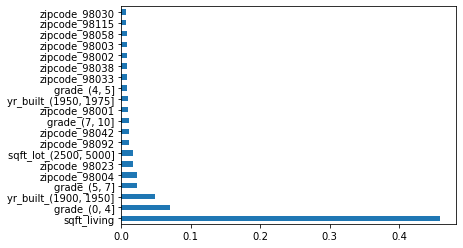

In [121]:
feat_importances = pd.Series(rf_model.feature_importances_, index = rfm_columns)
feat_importances.nlargest(20).plot(kind='barh')

#### OLS - 2

Using our OlS results summary let's take a look at our OLS model with features removed which have high std err and pvalues.

In [122]:
x_train1 = sm.add_constant(x_train_ols2)

In [123]:
x_test1 = sm.add_constant(x_test_ols2)

In [124]:
result = sm.OLS(y_train,x_train1).fit()

#### OLS model prediction - 2

In [125]:
print(result.rsquared, result.rsquared_adj)

0.8440335384876905 0.8432444388471411


In [126]:
print(result.summary(xname= xname2_columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     1070.
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:39:20   Log-Likelihood:                 2959.5
No. Observations:               17085   AIC:                            -5745.
Df Residuals:                   16998   BIC:                            -5071.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### Normality

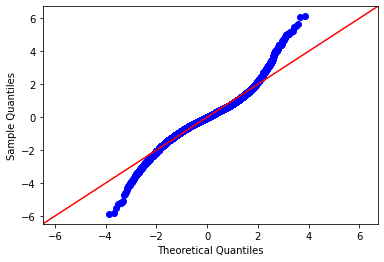

In [128]:
fig = sm.graphics.qqplot(result.resid, dist=stats.norm, line='45', fit=True)

Looks like the model does best at predicting mid priced houses and doesn't perform as well on low priced or high priced houses.

#### Homoskedasticity

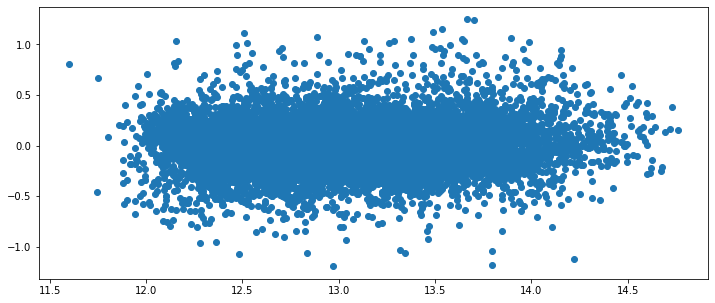

In [129]:
plt.figure(figsize=(12,5))
plt.scatter(result.predict(x_train1), result.resid)


Homoskedasticity looks ok

### k-fold cross validation

In [130]:
cross_validation_5 = KFold(5, shuffle=True)
cross_validation_10 = KFold(5, shuffle=True)
cross_validation_20 = KFold(5, shuffle=True)

In [131]:
# set scoring argument to 'neg_mean_squared_error'. This negates mean squared error, so larger means better!
cv_5_results  = np.mean(cross_val_score(linear_model, x, y, cv=cross_validation_5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linear_model, x, y, cv=cross_validation_10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linear_model, x, y, cv=cross_validation_20, scoring='neg_mean_squared_error'))

In [132]:
cv_5_results

nan

In [133]:
cv_10_results

nan

In [134]:
cv_20_results

nan

## Summary

Our final model has an r-squared-adjusted value of 0.84. 
Our model performs about the same with the train and test data so we don't seem to have an overfitting issue.
From the residuals in our qq plot looks like the model does best at predicting mid priced houses and doesn't perform as well on low priced or high priced houses. 
Homoskedasticity looked good in our visualization.

Our pricing model is most effective at estimating mid range  housing prices. It is not advisable to use this model for the low end  or high end of the King County housing market.


Expansion of data and more develpment could better improve the model to estimate low and high priced houses.


## Recommendations

- Sell houses in the Spring and Summer when the market is strong. More houses are purchased during this time and they tend to sell for higher prices.
- Our most important and reliable factor for predicting a home price is sqft_living. When pricing a house the overall square footage should be the most important factor.
- Waterfront properties will have a higher price to comparable properties.
- Properties with a grade of 4 and under will have a lower price to comparable properties. 
- Expand data set beyond houses sold in 2014 and 2015. Having more current data would make the model more accurate.

## Further Analysis

- Expand data set beyond houses sold in 2014 and 2015. Having more current data would make the model more accurate.
- Adjust modeling to better estimate low and high priced houses. 
 - Investigate what features would help us to estimate extremes
